# Mixed field Ising model simulation via Trotter circuit

In [ ]:
pip install pylatexenc 

     |████████████████████████████████| 163kB 5.4MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-cp37-none-any.whl size=136825 sha256=f4c8c1d05da08e5bdfa262ff258e6e651d5ab9277b239680402f9076e970e3eb
  Stored in directory: /root/.cache/pip/wheels/3d/0a/64/533613e8165f1fc42f8f727cd12bb240940e2bd3bae7829021
Successfully built pylatexenc


In [ ]:
!pip install qiskit 

     |████████████████████████████████| 6.0MB 4.0MB/s 
     |████████████████████████████████| 17.9MB 142kB/s 
     |████████████████████████████████| 204kB 48.6MB/s 
     |████████████████████████████████| 215kB 51.4MB/s 
     |████████████████████████████████| 2.1MB 42.4MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 1.0MB 38.8MB/s 
     |████████████████████████████████| 194kB 35.4MB/s 
     |████████████████████████████████| 81kB 6.9MB/s 
     |████████████████████████████████| 614kB 32.8MB/s 
     |████████████████████████████████| 3.2MB 39.5MB/s 
     |████████████████████████████████| 5.5MB 35.1MB/s 
  Created wheel for qiskit: filename=qiskit-0.25.0-cp37-none-any.whl size=3032 sha256=a9f819074daa974a3ddeae3fd1c5bbb81c83656ed26b1b29618b9e30ae156890
  Stored in directory: /root/.cache/pip/wheels/09/6e/f1/a7eaab6e3943d749f1b257f462f60fbc402b0c8e870b555169
  Created wheel for python-constraint: filename=python_constraint-1.4.0-py2

In [ ]:
from qiskit import *
from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np
from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from qiskit import IBMQ
IBMQ.save_account("26595118309e0ea848015d3f7458b040ec723a9c11afd2d777038533a5a2b8079312af1e3713e370053f85bf7dd5d77f72993b0f04c2cd561e4c31f5a40c910c")
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_qasm_simulator')
properties = backend.properties()

Mixed Ising model Hamiltonian:

$H=V\sum_{\left\langle i,j\right\rangle }Z_{i}Z_{j}+\Omega\sum_{i}X_{i}+h\sum_{i}Z_{i}$

where:  
i and j are nearest neighbors;  
Z is the magnetic field along with the z-axis;  
X is transverse field along with the x-axis;  
V is the nearest neighbor interaction strength;  
omega is the coupling strength of the transverse field magnitude;   
h is the magnetic field amplitude

In [ ]:

q=14 # number of qubits

# Z field
def h_Z(qc,h,dt):
    for i in range(q):
        qc.rz(2*h*dt,i)

# Transverse field along with the x-axis        
def X_Rabi(qc,Omega,dt):
    for i in range(q):
        qc.rx(2*Omega*dt,i)

# Nearest coupling         
def ZZ(qc,V,dt):
    
    for i in range(0,q,2):
        qc.cx(i,i+1)
    
        qc.rz(-2*V*dt,i+1)
    
        qc.cx(i,i+1)
    
    for j in range(1,q,2):
        qc.cx(j,(j+1)%q)
    
        qc.rz(-2*V*dt,(j+1)%q)
    
        qc.cx(j,(j+1)%q)

    

In [ ]:
def Trotter_circuit_q_site(h,Omega,V,T,n):
    Trotter_circuits = []
    dt=T/n
    for i in range(n):
        Trotter_circuit = QuantumCircuit(q)

        #Set up the initial state####
        
        #Trotter_circuit.x(0)
        Trotter_circuit.x(2)
        #Trotter_circuit.x(4)
        #Trotter_circuit.x(6)
        Trotter_circuit.x(8)
        #Trotter_circuit.x(10)
        #Trotter_circuit.x(12)

        ##################

        Trotter_circuit.barrier()
        for k in range(i):
            

            h_Z(Trotter_circuit,h,dt) # Z field 

            X_Rabi(Trotter_circuit,Omega,dt)
             
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        Trotter_circuits.append(Trotter_circuit)
    return Trotter_circuits
    
    

In [ ]:
Omega = 2*0.2 # The coupling strength of the transverse field magnitude (should be smaller than one but cannot be too small).
h = 2*2  # magnetic field amplitude parallel with Z axis
V =  2*1 # the nearest neighbor interaction strength
T = 45 # Total time for the time evolution of the Harmiltonian
NT = 180 # number of steps for the time evolution of the Harmiltonian
Trotter_circuit = Trotter_circuit_q_site(h,Omega,V,T,NT)

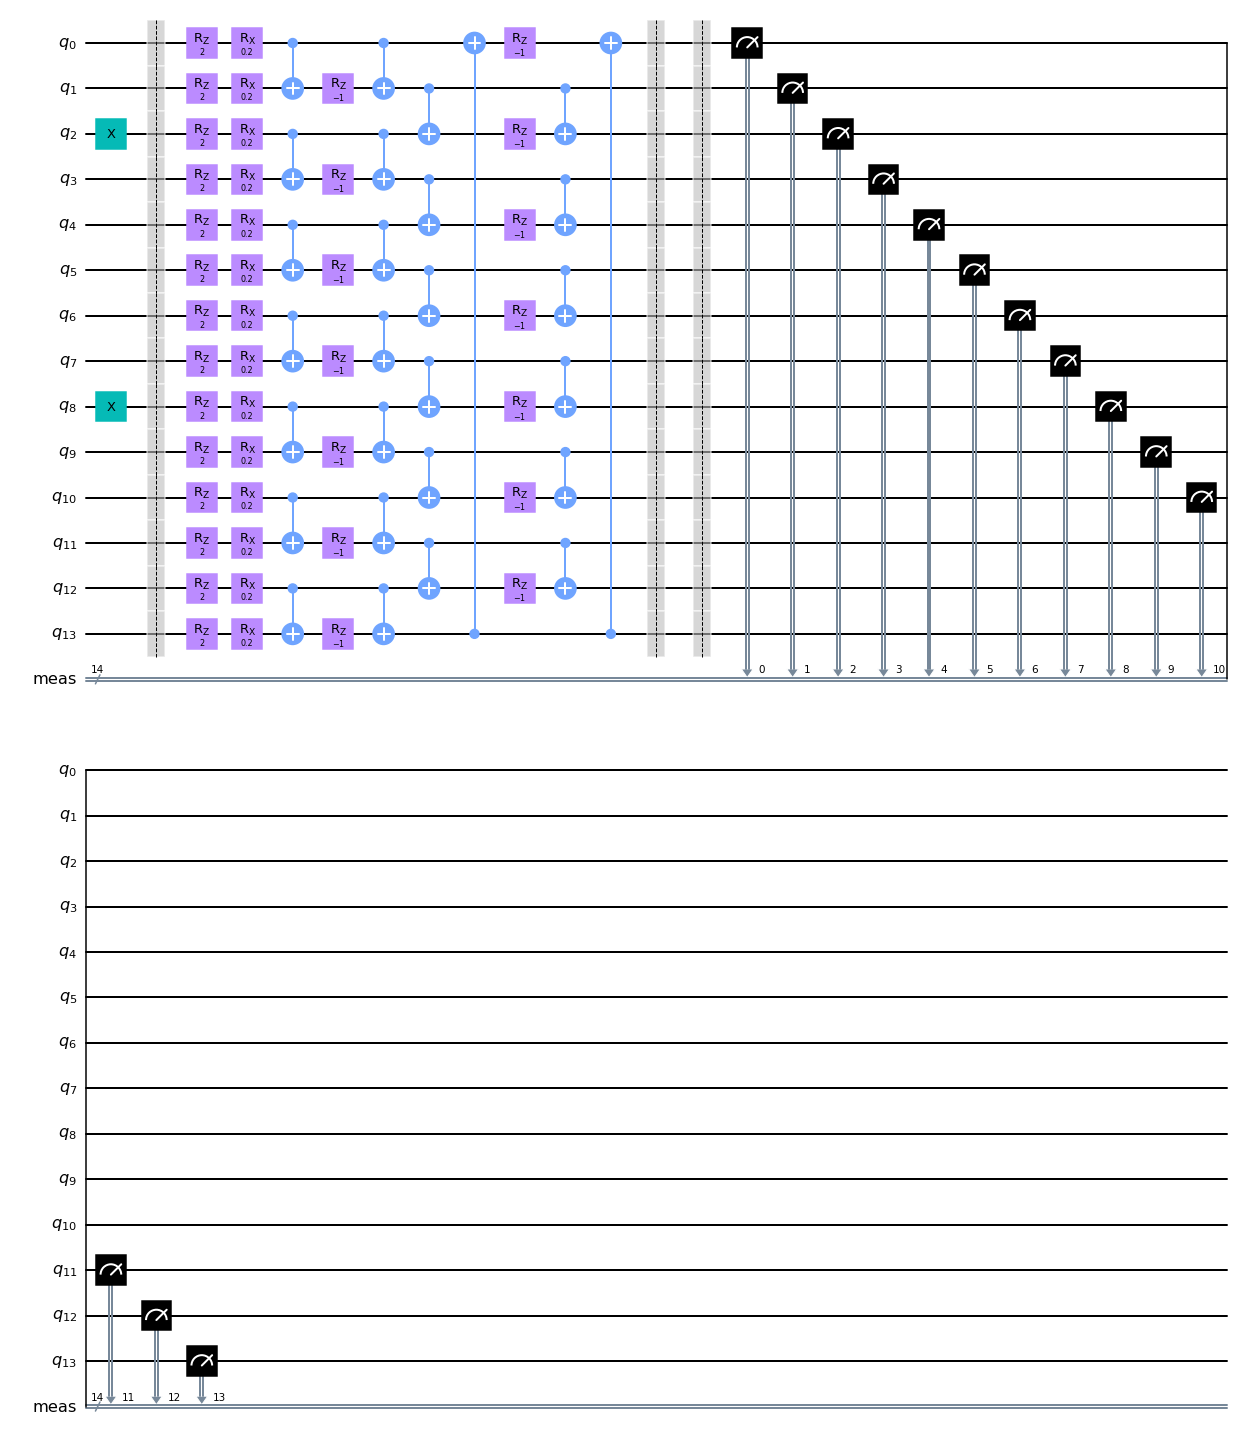

In [ ]:
# Plot the Trotter circuit
Trotter_circuit[1].draw(output = "mpl")

In [ ]:
shots = 8192 # number of measurements
il = [i for i in range(q)] # q is the number of qubits

Trotter_circuit_sim = execute(Trotter_circuit, backend, shots=shots, initial_layout=il)

In [ ]:
result_sim=Trotter_circuit_sim.result()
result=[]
for i in range(NT):
  result.append(result_sim.get_counts(i)) 

In [ ]:

Sz_sim = [] # expectation value of Z Pauli matrix on different sites 
for i in range(NT):
    tot_sim=np.zeros(q)
    Result_sim = result[i]
    for j in range(2**q):
        n=2**q
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim.append(tot_sim/8192)
Sz_sim=np.array(Sz_sim)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def reverse_colourmap(cmap, name = 'my_cmap_r'):
    """
    In: 
    cmap, name 
    Out:
    my_cmap_r

    Explanation:
    t[0] goes from 0 to 1
    row i:   x  y0  y1 -> t[0] t[1] t[2]
                   /
                  /
    row i+1: x  y0  y1 -> t[n] t[1] t[2]

    so the inverse should do the same:
    row i+1: x  y1  y0 -> 1-t[0] t[2] t[1]
                   /
                  /
    row i:   x  y1  y0 -> 1-t[n] t[2] t[1]
    """        
    reverse = []
    k = []   

    for key in cmap._segmentdata:    
        k.append(key)
        channel = cmap._segmentdata[key]
        data = []

        for t in channel:                    
            data.append((1-t[0],t[2],t[1]))            
        reverse.append(sorted(data))    

    LinearL = dict(zip(k,reverse))
    my_cmap_r = mpl.colors.LinearSegmentedColormap(name, LinearL) 
    return my_cmap_r

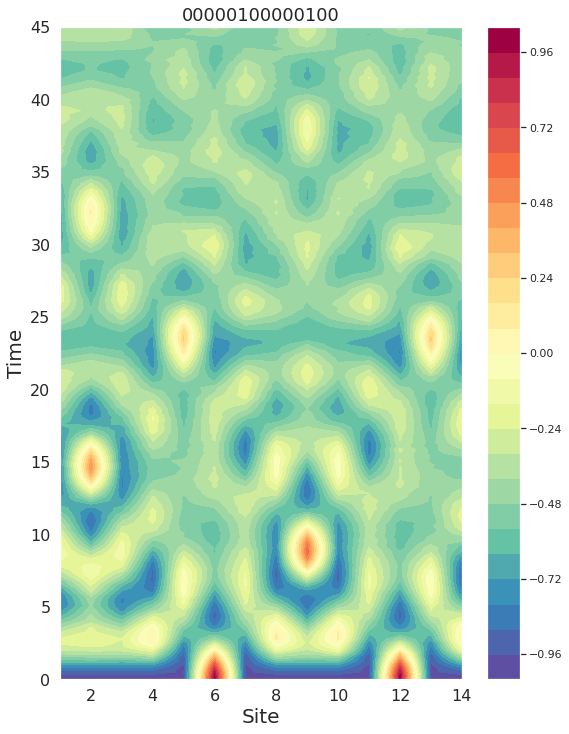

In [ ]:
t=np.linspace(0,T,NT)
l=np.linspace(1,q,q)
ll, tt = np.meshgrid(l, t)

my_cmap = mpl.cm.Spectral

my_cmap_r = reverse_colourmap(my_cmap)

#cmap_reversed = matplotlib.cm.get_cmap('Spectral_r')

fig, ax = plt.subplots(figsize=(9,12))
cg=ax.contourf(ll, tt, Sz_sim, 30, vmin=-1, vmax=1, cmap=my_cmap_r)
fig.colorbar(cg, ax=ax)

ax.set_title('00000100000100',fontsize=18)

ax.set_ylabel('Time', fontsize =20)
ax.set_xlabel('Site', fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

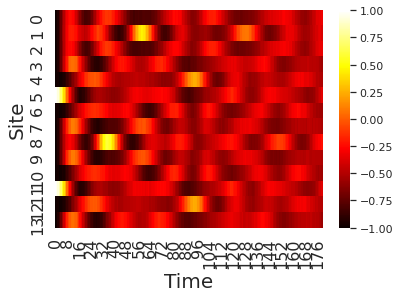

In [ ]:
import numpy as np
import cv2

import seaborn as sns; sns.set_theme()
#boulder_monthly_precip = [i+1 for i in range(180)]
#months = [(i+1)/4 for i in range(180)]
ax = sns.heatmap(np.transpose(Sz_sim), cmap="hot")

ax.set_xlabel('Time', fontsize =20)
ax.set_ylabel('Site', fontsize =20)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

# Exact Diagonlization

In [ ]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the ith site spin in n-state with system size L 
    # n-state: binary -> decimal
    ii=2**(L-i-1) # location of flipping state
    nn=2**L # Total number of states
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  

def spin_x(i,L): # Pauli X in site i
    n=2**L
    X=np.zeros((n,n))
    for j in range(n):
        X[j,flip(j,i,L)]=1
    return X

def spin_y(i,L): # Pauli Y in site i
    n=2**L
    Y=np.zeros((n,n),dtype=complex)
    for j in range(n):
        Y[j,flip(j,i,L)]=1j*(-1)**(int(bin(j+n)[3:][i]))
    return Y

def spin_z(i,L): # Pauli Z in site i
    n=2**L
    Z=np.zeros((n,n))
    #a=2**L-1
    for j in range(n):
        Z[j,j]=2*int(bin(j+n)[2:][::-1][i])-1
    return Z



In [ ]:
L=10

########### Adjustable parameters for optimized output ################
Omega = 0.2 # The Rabi coupling(frequency) should be smaller than one but cannot be too small.
h = 2  # Z field 
V = 1  # The nearest neighbor
#######################################################################




H0=0 # H0: magnetic field interaction term
for i in range(L):
    H0=H0+Omega*spin_x(i,L)+h*spin_z(i,L)


V0=0 # V0: nearest neighbor intercation term
for i in range(L):
    n_f=spin_z((i)%L,L)
    n_b=spin_z((i+1)%L,L)
    V0=V0+V*np.dot(n_f,n_b)


H=H0+V0 # Mixed field Ising model Harmiltonian

In [ ]:
vals, vecs = la.eigh(H) # eignvalues and eigenvectors
inds = np.argsort(vals) # sort the eigenvalues based on the magnitude
e = vals[inds] # e is the sorted eigenvalues
v = vecs[:,inds] # v is the eigenvectors corresponded to e

In [ ]:
binaryToDecimal(1000101010001) # initial state

4433

In [ ]:
########### Adjustable parameters for optimized output ################
Nt=180-1 # number steps
T=45 # Total time 
#######################################################################

dt=T/Nt

A=np.eye(len(e))*e
U=np.dot(v,np.dot(np.exp(-1j*A*dt)*np.eye(len(e)),np.conj(np.transpose(v))))

########### Adjustable parameters for optimized output ################
f = 273 # initial state
#######################################################################


wavefunc=np.zeros((len(e),Nt+1),dtype=complex)
n=np.zeros(len(e),dtype=complex)
n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=np.dot(U,wavefunc[:,i])


In [ ]:
def Zi_t_p(tf,dt,f,i):
  
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    return Zt1

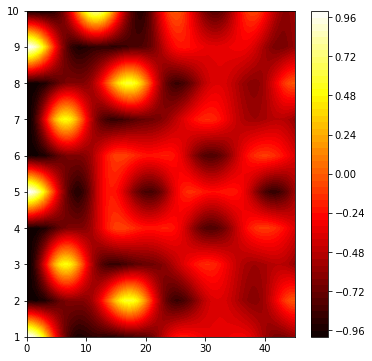

In [ ]:
Zi=np.zeros((L,Nt+1))
for i in range(L):
  
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))

t=np.linspace(0,T,Nt+1)
l=np.linspace(1,L,L)
T, LL = np.meshgrid(t, l)
#cmap = mpl.cm.hot
#norm = mpl.colors.Normalize(vmin=-1, vmax=1)
fig, ax = plt.subplots(figsize=(6,6))
cg = ax.contourf(T, LL, Zi, 50, vmin=-1, vmax=1, cmap='hot')
fig.colorbar(cg, ax=ax)
#plt.xscale('log')
#ax.set_xscale('log')
#ax.set_xlim(0,1e10)
plt.show()

In [ ]:
import numpy as np
import cv2

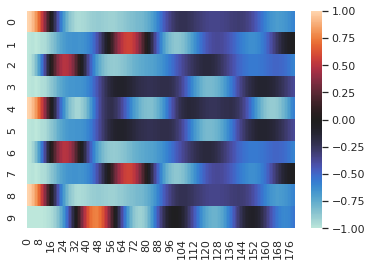

In [ ]:
import seaborn as sns; sns.set_theme()

ax = sns.heatmap(Zi, center=0)
